In [63]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from os import path
import itertools
import re

In [49]:
#
# all.csv contains one row per state with the name of the 
# agri data for that state
#
data = '../data/agri/all.csv'
files = pd.read_csv(data)

states = []
frames = []
for st,fn in files.values.tolist():
    frame = pd.read_csv(path.join('../data/agri', fn))
    frame['state'] = st
    states.append(st)
    frames.append(frame)


In [70]:
agri = pd.concat(frames)
#
# Preprocess - convert value to float and invalid values to None
#
def to_float(x):
    try:
        if type(x) == float:
            return x
        x = x.strip()
        if x == '(Z)':
            return 0.0
        x = x.replace(',','')
        return float(x)
    except ValueError:
        return float('NaN')

agri.Value = agri.Value.apply(to_float)
agri = agri[~np.isnan(agri.Value)]
#
# Rename Data Item to DataItem so it can be used as an attribute
# Rename Year to year to match weather data
# Also get rid of some columns we don't need
#
agri['DataItem'] = agri['Data Item']
agri['year'] = agri['Year']
agri = agri.drop(['Data Item', 'Year', 'Program', 'Domain', 'Domain Category'],  1)

def crop(di):
    '''
    Extract specific type of crop from DataItem field
    '''
    di = [x for x in di.split(', ') if ' - YIELD' in x]
    if not di:
        return None
    return di[0].split(' ')[0]

measure = re.compile('MEASURED IN (.*) / ACRE')

def unit(di):
    '''
    Extract units of measure from DataItem field
    '''
    di = [measure.match(x) for x in di.split(', ')]
    di = [x for x in di if x]
    if not di:
        return None
    return di[0].group(1)

#
# Add columns for detailed crop and units
#
agri['crop'] = agri.Commodity + ':' + agri.DataItem.apply(crop)
agri['unit'] = agri.DataItem.apply(unit)

#
# We are only interested in items per acre
#
agri = agri[agri.DataItem.str.contains('/ ACRE')]
agri

,Commodity,Value,state,DataItem,year,crop,unit
7929,BARLEY,93.3,CA,"BARLEY, IRRIGATED, ENTIRE CROP - YIELD, MEASUR...",2007,BARLEY:ENTIRE,BU
7932,BARLEY,31.9,CA,"BARLEY, IRRIGATED, NONE OF CROP - YIELD, MEASU...",2007,BARLEY:NONE,BU
7934,BARLEY,37.8,CA,"BARLEY, IRRIGATED, PART OF CROP - YIELD, MEASU...",2007,BARLEY:PART,BU
7986,BEANS,21.6,CA,"BEANS, DRY EDIBLE, (EXCL LIMA), INCL CHICKPEAS...",2007,BEANS:ENTIRE,CWT
8617,CORN,182.2,CA,"CORN, GRAIN, IRRIGATED, ENTIRE CROP - YIELD, M...",2007,CORN:ENTIRE,BU
...,...,...,...,...,...,...,...
17435,TOBACCO,1380.0,WI,"TOBACCO, CIGAR BINDER NORTHERN WISCONSIN (TYPE...",1960,TOBACCO:CIGAR,LB
17439,TOBACCO,1510.0,WI,"TOBACCO, CIGAR BINDER SOUTHERN WISCONSIN (TYPE...",1960,TOBACCO:CIGAR,LB
17444,WHEAT,33.2,WI,"WHEAT - YIELD, MEASURED IN BU / ACRE",1960,WHEAT:WHEAT,BU
17449,WHEAT,28.0,WI,"WHEAT, SPRING, (EXCL DURUM) - YIELD, MEASURED ...",1960,WHEAT:(EXCL,BU


In [85]:
#
# Split the data up into yields by state
#
bystate = {}
for st in states:
    stdata = agri[agri.state == st]
    crop = list(set(stdata.crop))
    crops = {}
    for c in crop:
        rows = stdata[stdata.crop == c]
        if not rows.empty:
            crops[c] = rows
        
    bystate[st] = crops
    

In [158]:
#
# Aggregate weather data over growing season and split by state
#
data = '../data/wx/wxsummary.csv'
wx = pd.read_csv(data)
wxstates = list(set(wx.state))

beg = 'may'
end = 'sep'

wxmeans = wx.loc[:, beg:end].mean(axis=1)
wxsums  = wx.loc[:, beg:end].sum(axis=1)
wxmaxs  = wx.loc[:, beg:end].max(axis=1)
wxmins  = wx.loc[:, beg:end].min(axis=1)


wx['mean'] = wxmeans
wx['sum'] = wxsums
wx['max'] = wxmaxs
wx['min'] = wxmins

wx_by_state = {}

for st in wxstates:
    prcp = wx[(wx.state == st) & (wx.type == 'prcp')][['year', 'sum']]
    tavg = wx[(wx.state == st) & (wx.type == 'tavg')][['year', 'mean']]
    tmin = wx[(wx.state == st) & (wx.type == 'tmin')][['year', 'min']]
    tmax = wx[(wx.state == st) & (wx.type == 'tmax')][['year', 'max']]
    df = pd.merge(prcp, tavg, on='year')
    df = pd.merge(df, tmin, on='year')
    df = pd.merge(df, tmax, on='year')
    df['prcp'] = df['sum']
    df['tavg'] = df['mean']
    df['tmin'] = df['min']
    df['tmax'] = df['max']
    df = df.drop(['sum', 'mean', 'min', 'max'], 1)
    wx_by_state[st] = df
    
    

In [162]:
rows = []
for st in bystate.keys():
    for commod in bystate[st].keys():
        merge = pd.merge(bystate[st][commod], wx_by_state[st], on='year')
        if len(merge) < 15:
            continue
        row = [st, commod, len(merge), merge.Value.corr(merge['prcp'])]
        row.append(abs(row[3]))
        row += [merge_tavg.Value.corr(merge['tavg'])]
        row.append(abs(row[5]))
        
        rows.append(row)
    
corrs = pd.DataFrame(rows, columns=['state', 'crop', 'years', 'prcp_corr', 'abs_prcp_corr', 'tavg_corr', 'abs_tavg_corr'])

,state,crop,years,prcp_corr,abs_prcp_corr,tavg_corr,abs_tavg_corr
0,CA,BEANS:INCL,50,0.008503,0.008503,0.535761,0.535761
1,CA,WHEAT:FOLLOWING,44,-0.405881,0.405881,-0.767093,0.767093
2,CA,ORANGES:VALENCIA,32,0.263994,0.263994,0.535761,0.535761
3,CA,RICE:LONG,28,-0.077160,0.077160,0.535761,0.535761
4,CA,BARLEY:CONTINUOUS,22,-0.128712,0.128712,-0.428853,0.428853
...,...,...,...,...,...,...,...
369,WI,CORN:SILAGE,50,0.144944,0.144944,-0.919016,0.919016
370,WI,RYE:RYE,40,-0.002786,0.002786,0.606348,0.606348
371,WI,WHEAT:(EXCL,49,0.183685,0.183685,-0.620204,0.620204
372,WI,MINT:OIL,56,-0.341190,0.341190,-0.767093,0.767093


In [160]:
with pd.option_context('display.max_rows', None):
    print(corrs[['state', 'crop', 'years', 'prcp_corr', 'abs_prcp_corr']].sort_values('abs_prcp_corr', ascending=False).head(20))


    state                    crop  years  prcp_corr  abs_prcp_corr
240    NE              BEANS:NAVY     19  -0.732293       0.732293
334    SD       BARLEY:CONTINUOUS     24   0.656700       0.656700
329    SD             HAY:ALFALFA     50   0.616309       0.616309
328    SD        WHEAT:CONTINUOUS    100   0.604286       0.604286
301    OH               HAY:(EXCL     55   0.597146       0.597146
333    SD        BARLEY:FOLLOWING     24   0.589084       0.589084
366    WI   HAY & HAYLAGE:ALFALFA     16   0.589050       0.589050
20     CA     TOMATOES:PROCESSING     21  -0.566086       0.566086
82     IN               OATS:OATS     50   0.560359       0.560359
357    WI       HAY & HAYLAGE:HAY     16   0.545674       0.545674
237    NE            BEANS:KIDNEY     23  -0.530173       0.530173
341    SD                 HAY:HAY     50   0.524799       0.524799
273    ND             HAY:ALFALFA     50   0.510436       0.510436
133    KS   SORGHUM:NON-IRRIGATED     40   0.510109       0.51

In [161]:
with pd.option_context('display.max_rows', None):
    print(corrs[['state', 'crop', 'years', 'tavg_corr', 'abs_tavg_corr']].sort_values('abs_tavg_corr', ascending=False).head(20))
    

    state                   crop  years  tavg_corr  abs_tavg_corr
368    WI        TOBACCO:TOBACCO     45  -0.981427       0.981427
347    SD                RYE:RYE     45  -0.963722       0.963722
23     CA        WHEAT:IRRIGATED    106   0.943530       0.943530
5      CA    WHEAT:NON-IRRIGATED     72   0.943530       0.943530
176    MN            WHEAT:DURUM     45  -0.939209       0.939209
163    MI      POTATOES:POTATOES     50  -0.923216       0.923216
164    MI        BEANS:CRANBERRY     23  -0.923216       0.923216
141    MI             BEANS:INCL     50  -0.923216       0.923216
142    MI      SOYBEANS:SOYBEANS     50  -0.923216       0.923216
143    MI                HAY:HAY     50  -0.923216       0.923216
144    MI            CORN:SILAGE     50  -0.923216       0.923216
145    MI            BEANS:BLACK     23  -0.923216       0.923216
146    MI              BEANS:RED     15  -0.923216       0.923216
160    MI  SUGARBEETS:SUGARBEETS     50  -0.923216       0.923216
148    MI 

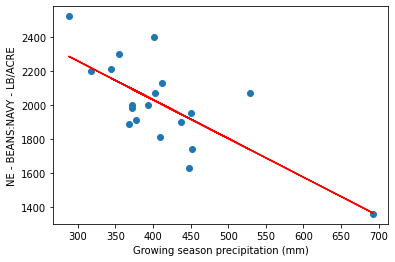

In [167]:
state = 'NE'
crop = 'BEANS:NAVY'
merged = pd.merge(bystate[state][crop], wx_by_state[state][['year','prcp']], on='year')
model = linear_model.LinearRegression()

meanprcp = [[x] for x in merged['prcp']]
model.fit(meanprcp, merged.Value)

m = model.coef_[0]
b = model.intercept_

ax = plt.axes()
plt.scatter(merged['prcp'], merged.Value)
plt.plot(merged['prcp'], m * merged['prcp'] + b, color='red')
ax.set_xlabel('Growing season precipitation (mm)')
ax.set_ylabel('%s - %s - %s/ACRE' % (state, crop, unit))
plt.show()


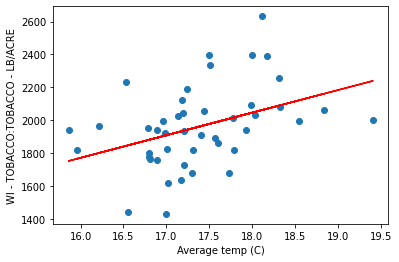

In [165]:
state = 'WI'
crop = 'TOBACCO:TOBACCO'
merged = pd.merge(bystate[state][crop], wx_by_state[state][['year', 'tavg']], on='year')
model = linear_model.LinearRegression()
unit = list(merged.unit)[0]

meantavg = [[x] for x in merged['tavg']]
model.fit(meantavg, merged.Value)

m = model.coef_[0]
b = model.intercept_
ax = plt.axes()
plt.scatter(merged['tavg'], merged.Value)
plt.plot(merged['tavg'], m * merged['tavg'] + b, color='red')
ax.set_xlabel('Average temp (C)')
ax.set_ylabel('%s - %s - %s/ACRE' % (state, crop, unit))
plt.show()